In [1]:
import warnings
warnings.filterwarnings("ignore")

import env
import Liam_wrangle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import viz_kmeans
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy import stats

import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('train_zillow.csv')

In [3]:
def split_zillow(df):
    '''This fuction takes in a df 
    splits into train, test, validate
    return: three pandas dataframes: train, validate, test
    '''
    # split the focused zillow data
    train_validate, test = train_test_split(df, test_size=.2, random_state=1234)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=1234)
    return train, validate, test

In [4]:
train, validate, test = split_zillow(df)

In [5]:
def scale_my_data(train, validate, test):
    scale_columns = ['bathrooms', 'bedrooms', 'quality', 
              'square_feet', 'full_bathrooms', 
              'latitude', 'longitude', 'lot_square_feet',  
              'land_type', 'city', 'county', 'zip_code', 
             'room_count', 'unitcnt', 'structure_tax_value', 
             'tax_value',  'land_tax_value', 'taxamount',
              'house_age', 'tax_rate', 'acres']
    scaler = MinMaxScaler()
    scaler.fit(train[scale_columns])

    train_scaled = scaler.transform(train[scale_columns])
    validate_scaled = scaler.transform(validate[scale_columns])
    test_scaled = scaler.transform(test[scale_columns])
    #turn into dataframe
    train_scaled = pd.DataFrame(train_scaled)
    validate_scaled = pd.DataFrame(validate_scaled)
    test_scaled = pd.DataFrame(test_scaled)
    
    return train_scaled, validate_scaled, test_scaled

In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [7]:
train_scaled, validate_scaled, test_scaled = scale_my_data(train, validate, test)

In [8]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [9]:
kmeans = KMeans(n_clusters=5, random_state=123)

In [10]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [11]:
# identify columns we want to cluster on
cluster_cols = ['longitude', 'latitude', 'house_age']

In [12]:
# clustering on train, getting the cetnoids
kmeans = kmeans.fit(train[cluster_cols])

In [13]:
# identifying clusters in train
train['longitude_latitude_houseage_cluster'] = kmeans.predict(train[cluster_cols])

In [14]:
# identifying clusters in validate, test
validate['longitude_latitude_houseage_cluster'] = kmeans.predict(validate[cluster_cols])
test['longitude_latitude_houseage_cluster'] = kmeans.predict(test[cluster_cols])

In [15]:
def predict_cluster(some_dataframe):
    some_dataframe['longitude_latitude_houseage_cluster'] = kmeans.predict(some_dataframe[cluster_cols])
    return some_dataframe

In [16]:
# look at overall counts of observations by cluster
train.longitude_latitude_houseage_cluster.value_counts()

1    6563
2    5075
4    4568
3    1404
0    1120
Name: longitude_latitude_houseage_cluster, dtype: int64

In [17]:
# look at overall counts of observations by cluster
validate.longitude_latitude_houseage_cluster.value_counts()

1    2843
2    2131
4    1951
3     593
0     510
Name: longitude_latitude_houseage_cluster, dtype: int64

In [18]:
# look at overall counts of observations by cluster
test.longitude_latitude_houseage_cluster.value_counts()

1    2305
2    1796
4    1654
3     514
0     421
Name: longitude_latitude_houseage_cluster, dtype: int64

In [19]:
def get_dummy_longitude_latitude_houseage_cluster(some_dataframe):
    dummy_df =  pd.get_dummies(some_dataframe['longitude_latitude_houseage_cluster'])
    dummy_df.columns = ['Ventura', 'Orange County', 
                    'North downtown LA', 'East downtown LA', 
                    'North LA']
    some_dataframe = pd.concat([some_dataframe, dummy_df], axis=1)
    some_dataframe = some_dataframe.drop(['Orange County', 'East downtown LA', 
                    'North downtown LA', 'longitude_latitude_houseage_cluster'], axis=1)
    return some_dataframe

In [20]:
def prep_longitude_latitude_houseage_clusters(some_dataframe):
    some_dataframe = predict_cluster(some_dataframe)
    some_dataframe = get_dummy_longitude_latitude_houseage_cluster(some_dataframe)
    return some_dataframe

In [21]:
train = prep_longitude_latitude_houseage_clusters(train)

In [22]:
validate = prep_longitude_latitude_houseage_clusters(validate)

In [23]:
test = prep_longitude_latitude_houseage_clusters(test)

In [24]:
train.head()

,parcelid,land_type,has_heating_system,bathrooms,bedrooms,quality,square_feet,fips,has_fireplace,full_bathrooms,...,in_ventura,house_age,tax_rate,acres,level_of_log_error,square_feet_bins,lot_sqft_bins,acre_bins,Ventura,North LA
18796,12086611,266.0,1,2.0,3.0,8.0,1543.0,6037.0,0.0,2.0,...,0,37.0,81.643225,0.510560,Accurate,1.5l-2k,20k-30k,0-15,0,0
3518,17086463,261.0,0,3.0,4.0,6.0,1719.0,6111.0,1.0,3.0,...,1,64.0,93.685084,0.189991,Accurate,1.5l-2k,0-10k,0-15,0,0
15170,10764495,266.0,1,3.0,2.0,8.0,1170.0,6037.0,0.0,3.0,...,0,42.0,80.349200,3.348600,Accurate,1k-1.5k,70+,0-15,0,1
13451,11080027,261.0,1,2.0,3.0,8.0,2049.0,6037.0,0.0,2.0,...,0,47.0,79.989777,0.268939,Accurate,2k-2.5k,10k-20k,0-15,0,1
28664,14225001,261.0,0,2.0,4.0,6.0,1660.0,6059.0,1.0,2.0,...,0,59.0,89.914255,0.195133,Accurate,1.5l-2k,0-10k,0-15,0,0


In [25]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [26]:
kmeans = KMeans(n_clusters=6, random_state=123)

In [27]:
# identify columns we want to cluster on
cluster_cols = ['structure_tax_value', 'land_tax_value']

In [28]:
# clustering on train, getting the cetnoids
kmeans = kmeans.fit(train[cluster_cols])

In [29]:
# identifying clusters in train
train['taxes_cluster'] = kmeans.predict(train[cluster_cols])

In [30]:
# identifying clusters in validate, test
validate['taxes_cluster'] = kmeans.predict(validate[cluster_cols])
test['taxes_cluster'] = kmeans.predict(test[cluster_cols])

In [31]:
def predict_cluster(some_dataframe):
    some_dataframe['taxes_cluster'] = kmeans.predict(some_dataframe[cluster_cols])
    return some_dataframe

In [32]:
# look at overall counts of observations by cluster
train.taxes_cluster.value_counts()

0    6493
2    4049
1    3029
4    2825
3    1303
5    1031
Name: taxes_cluster, dtype: int64

In [33]:
# look at overall counts of observations by cluster
validate.taxes_cluster.value_counts()

0    2786
2    1731
1    1266
4    1183
3     610
5     452
Name: taxes_cluster, dtype: int64

In [34]:
# look at overall counts of observations by cluster
test.taxes_cluster.value_counts()

0    2350
2    1434
1    1096
4     972
3     448
5     390
Name: taxes_cluster, dtype: int64

In [35]:
def get_dummy_taxes_cluster(some_dataframe):
    dummy_df =  pd.get_dummies(some_dataframe['taxes_cluster'])
    dummy_df.columns = ['low_structure_and_land_tax', 'drop1',
                        'drop2', 'medium_structure_low_land_tax', 
                        'drop4', 'drop5']
    some_dataframe = pd.concat([some_dataframe, dummy_df], axis=1)
    some_dataframe = some_dataframe.drop(['drop1', 'drop2', 'drop4', 'drop5', 'taxes_cluster'], axis=1)
    return some_dataframe

In [36]:
def prep_taxes_clusters(some_dataframe):
    some_dataframe = predict_cluster(some_dataframe)
    some_dataframe = get_dummy_taxes_cluster(some_dataframe)
    return some_dataframe

In [37]:
train = prep_taxes_clusters(train)

In [38]:
validate = prep_taxes_clusters(validate)

In [39]:
test = prep_taxes_clusters(test)

In [40]:
train.head()

,parcelid,land_type,has_heating_system,bathrooms,bedrooms,quality,square_feet,fips,has_fireplace,full_bathrooms,...,tax_rate,acres,level_of_log_error,square_feet_bins,lot_sqft_bins,acre_bins,Ventura,North LA,low_structure_and_land_tax,medium_structure_low_land_tax
18796,12086611,266.0,1,2.0,3.0,8.0,1543.0,6037.0,0.0,2.0,...,81.643225,0.510560,Accurate,1.5l-2k,20k-30k,0-15,0,0,1,0
3518,17086463,261.0,0,3.0,4.0,6.0,1719.0,6111.0,1.0,3.0,...,93.685084,0.189991,Accurate,1.5l-2k,0-10k,0-15,0,0,0,0
15170,10764495,266.0,1,3.0,2.0,8.0,1170.0,6037.0,0.0,3.0,...,80.349200,3.348600,Accurate,1k-1.5k,70+,0-15,0,1,1,0
13451,11080027,261.0,1,2.0,3.0,8.0,2049.0,6037.0,0.0,2.0,...,79.989777,0.268939,Accurate,2k-2.5k,10k-20k,0-15,0,1,0,0
28664,14225001,261.0,0,2.0,4.0,6.0,1660.0,6059.0,1.0,2.0,...,89.914255,0.195133,Accurate,1.5l-2k,0-10k,0-15,0,0,0,0


In [41]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [42]:
kmeans = KMeans(n_clusters=5, random_state=123)

In [43]:
# identify columns we want to cluster on
cluster_cols = ['quality', 'house_age', 'room_count']

In [44]:
# clustering on train, getting the cetnoids
kmeans = kmeans.fit(train[cluster_cols])

In [45]:
# identifying clusters in train
train['quality_houseage_roomcount_cluster'] = kmeans.predict(train[cluster_cols])

In [46]:
# identifying clusters in validate, test
validate['quality_houseage_roomcount_cluster'] = kmeans.predict(validate[cluster_cols])
test['quality_houseage_roomcount_cluster'] = kmeans.predict(test[cluster_cols])

In [47]:
def predict_cluster(some_dataframe):
    some_dataframe['quality_houseage_roomcount_cluster'] = kmeans.predict(some_dataframe[cluster_cols])
    return some_dataframe

In [48]:
# look at overall counts of observations by clustert
train.quality_houseage_roomcount_cluster.value_counts()

4    5690
2    4609
0    4563
3    2131
1    1737
Name: quality_houseage_roomcount_cluster, dtype: int64

In [49]:
# look at overall counts of observations by cluster
validate.quality_houseage_roomcount_cluster.value_counts()

4    2374
0    2004
2    1949
3     968
1     733
Name: quality_houseage_roomcount_cluster, dtype: int64

In [50]:
# look at overall counts of observations by cluster
test.quality_houseage_roomcount_cluster.value_counts()

4    2062
0    1665
2    1550
3     782
1     631
Name: quality_houseage_roomcount_cluster, dtype: int64

In [51]:
def get_dummy_quality_houseage_roomcount_cluster(some_dataframe):
    dummy_df =  pd.get_dummies(some_dataframe['quality_houseage_roomcount_cluster'])
    dummy_df.columns = ['house quality = 0', 
                    'Older homes low quality', 
                    'Younger homes avg. quality', 
                    'Newer Homes High Quality', 
                    'Older Homes High Quality']
    some_dataframe = pd.concat([some_dataframe, dummy_df], axis=1)
    some_dataframe = some_dataframe.drop(['Older homes low quality', 
                    'Younger homes avg. quality', 
                    'quality_houseage_roomcount_cluster'], axis=1)
    return some_dataframe

In [52]:
def prep_quality_houseage_roomcount_clusters(some_dataframe):
    some_dataframe = predict_cluster(some_dataframe)
    some_dataframe = get_dummy_quality_houseage_roomcount_cluster(some_dataframe)
    return some_dataframe

In [53]:
train = prep_quality_houseage_roomcount_clusters(train)

In [54]:
validate = prep_quality_houseage_roomcount_clusters(validate)

In [55]:
test = prep_quality_houseage_roomcount_clusters(test)

In [56]:
train.head()

,parcelid,land_type,has_heating_system,bathrooms,bedrooms,quality,square_feet,fips,has_fireplace,full_bathrooms,...,square_feet_bins,lot_sqft_bins,acre_bins,Ventura,North LA,low_structure_and_land_tax,medium_structure_low_land_tax,house quality = 0,Newer Homes High Quality,Older Homes High Quality
18796,12086611,266.0,1,2.0,3.0,8.0,1543.0,6037.0,0.0,2.0,...,1.5l-2k,20k-30k,0-15,0,0,1,0,1,0,0
3518,17086463,261.0,0,3.0,4.0,6.0,1719.0,6111.0,1.0,3.0,...,1.5l-2k,0-10k,0-15,0,0,0,0,0,0,1
15170,10764495,266.0,1,3.0,2.0,8.0,1170.0,6037.0,0.0,3.0,...,1k-1.5k,70+,0-15,0,1,1,0,1,0,0
13451,11080027,261.0,1,2.0,3.0,8.0,2049.0,6037.0,0.0,2.0,...,2k-2.5k,10k-20k,0-15,0,1,0,0,0,0,0
28664,14225001,261.0,0,2.0,4.0,6.0,1660.0,6059.0,1.0,2.0,...,1.5l-2k,0-10k,0-15,0,0,0,0,0,0,0


In [57]:
validate.head()

,parcelid,land_type,has_heating_system,bathrooms,bedrooms,quality,square_feet,fips,has_fireplace,full_bathrooms,...,square_feet_bins,lot_sqft_bins,acre_bins,Ventura,North LA,low_structure_and_land_tax,medium_structure_low_land_tax,house quality = 0,Newer Homes High Quality,Older Homes High Quality
23193,13059280,261.0,1,3.0,4.0,8.0,2155.0,6037.0,0.0,3.0,...,2k-2.5k,20k-30k,0-15,0,0,0,1,1,0,0
3699,12282400,261.0,0,2.0,3.0,4.0,1487.0,6037.0,0.0,2.0,...,1k-1.5k,0-10k,0-15,0,0,1,0,0,0,0
11406,11872875,261.0,1,2.0,3.0,6.0,1279.0,6037.0,0.0,2.0,...,1k-1.5k,0-10k,0-15,0,0,0,0,0,0,1
16924,14239107,261.0,0,1.5,2.0,6.0,1167.0,6059.0,0.0,1.0,...,1k-1.5k,0-10k,0-15,0,0,0,0,1,0,0
31134,14122618,261.0,0,1.5,4.0,6.0,1314.0,6059.0,0.0,1.0,...,1k-1.5k,0-10k,0-15,0,0,1,0,0,0,1


In [58]:
test.head()

,parcelid,land_type,has_heating_system,bathrooms,bedrooms,quality,square_feet,fips,has_fireplace,full_bathrooms,...,square_feet_bins,lot_sqft_bins,acre_bins,Ventura,North LA,low_structure_and_land_tax,medium_structure_low_land_tax,house quality = 0,Newer Homes High Quality,Older Homes High Quality
15693,10926937,261.0,1,4.0,5.0,6.0,2336.0,6037.0,0.0,4.0,...,2k-2.5k,0-10k,0-15,0,1,0,0,0,0,0
8989,10830570,261.0,1,2.0,4.0,6.0,1674.0,6037.0,0.0,2.0,...,1.5l-2k,10k-20k,0-15,0,1,0,0,0,0,0
29206,11850232,261.0,1,2.0,4.0,4.0,1974.0,6037.0,0.0,2.0,...,1.5l-2k,0-10k,0-15,0,0,0,0,0,0,1
22314,11300905,263.0,0,2.0,3.0,8.0,1926.0,6037.0,0.0,2.0,...,1.5l-2k,0-10k,0-15,1,0,1,0,0,1,0
10255,12136656,261.0,1,2.0,3.0,6.0,1531.0,6037.0,0.0,2.0,...,1.5l-2k,0-10k,0-15,0,0,1,0,0,0,1


In [59]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [62]:
def focused_zillow(train, validate, test):
    '''
    takes in train
    sets sepecific features to focus on
    returns a focused data frame in a pandas dataframe
    '''
    # choose features to focus on
    features = [
    'logerror',
    'latitude',
    'longitude',
    'Ventura',
    'North LA',
    'low_structure_and_land_tax',
    'medium_structure_low_land_tax',
    'house quality = 0',
    'Newer Homes High Quality',
    'Older Homes High Quality'] # the target
    # return a df based only on these features
    train = train[features]
    validate = validate[features]
    test = test[features]
    return train, validate, test

In [64]:
train, validate, test = focused_zillow(train, validate, test)

In [65]:
train.head()

,logerror,latitude,longitude,Ventura,North LA,low_structure_and_land_tax,medium_structure_low_land_tax,house quality = 0,Newer Homes High Quality,Older Homes High Quality
18796,0.105114,34144131.0,-118226980.0,0,0,1,0,1,0,0
3518,0.058315,34282122.0,-119222749.0,0,0,0,0,0,0,1
15170,0.026213,34202000.0,-118553000.0,0,1,1,0,1,0,0
13451,-0.041705,34263422.0,-118553049.0,0,1,0,0,0,0,0
28664,-0.054827,33817418.0,-117845250.0,0,0,0,0,0,0,0


# Modeling

In [66]:
def split_train_validate_test(train, validate, test):
    ''' This function takes in train, validate and test
    splits them into X and y versions
    returns X_train, X_validate, X_test, y_train, y_validate, y_test'''
    X_train = train.drop(columns = ['logerror'])
    y_train = train.logerror
    X_validate = validate.drop(columns=['logerror'])
    y_validate = validate.logerror
    X_test = test.drop(columns=['logerror'])
    y_test = test.logerror
    return X_train, X_validate, X_test, y_train, y_validate, y_test

In [67]:
X_train, X_validate, X_test, y_train, y_validate, y_test = split_train_validate_test(train, validate, test)

In [68]:
X_train.head()

,latitude,longitude,Ventura,North LA,low_structure_and_land_tax,medium_structure_low_land_tax,house quality = 0,Newer Homes High Quality,Older Homes High Quality
18796,34144131.0,-118226980.0,0,0,1,0,1,0,0
3518,34282122.0,-119222749.0,0,0,0,0,0,0,1
15170,34202000.0,-118553000.0,0,1,1,0,1,0,0
13451,34263422.0,-118553049.0,0,1,0,0,0,0,0
28664,33817418.0,-117845250.0,0,0,0,0,0,0,0


In [69]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
# modeling methods
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import f_regression 

# Baseline

In [81]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
    # turn it into a single pandas dataframe
y_validate = pd.DataFrame(y_validate)
    # wrap them as dataframes
# 1. Predict appraised_value_pred_mean
    # 2 different aselines of mean and medium
logerror_pred_mean = y_train['logerror'].mean()
y_train['logerror_pred_mean'] = logerror_pred_mean
y_validate['logerror_pred_mean'] = logerror_pred_mean
# 2. compute appraised_value_pred_median
    # same process as mean (above)
logerror_pred_median = y_train['logerror'].median()
y_train['logerror_pred_median'] = logerror_pred_median
y_validate['logerror_pred_median'] = logerror_pred_median
# 3. RMSE of appraised_value_pred_mean
rmse_train_mean = mean_squared_error(y_train.logerror, 
                                     y_train.logerror_pred_mean)**(1/2)
    # stick with root mean square error
        # not your only option but that is what we will be using here
            # just because it is eaiest to us and explain
    # remember when you call you it will be your y_true and y_pred
rmse_validate_mean = mean_squared_error(y_validate.logerror, 
                                        y_validate.logerror_pred_mean)**(1/2)
    # do the same thing for the validate set as done above for the train set
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train_mean, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_mean, 2))
print(' ')
# 4. RMSE of appraised_value_pred_median
rmse_train_medium = mean_squared_error(y_train.logerror, 
                                       y_train.logerror_pred_median)**(1/2)
rmse_validate_medium = mean_squared_error(y_validate.logerror, 
                                          y_validate.logerror_pred_median)**(1/2)
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train_medium, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_medium, 2))
# median comes out a little higher than mean 
    # but a little lower than our validation set

RMSE using Mean
Train/In-Sample:  0.16 
Validate/Out-of-Sample:  0.15
 


NameError: name 'median_squared_error' is not defined

In [71]:
validate.sample()

,logerror,latitude,longitude,Ventura,North LA,low_structure_and_land_tax,medium_structure_low_land_tax,house quality = 0,Newer Homes High Quality,Older Homes High Quality
20895,0.013607,34261146.0,-118302589.0,0,1,0,0,0,0,1


# OLS Model

In [72]:
# create the model object
lm = LinearRegression(normalize=True)
# fit the model to our training data. We must specify the column in y_train,
# since we have converted it to a dataframe from a series!
lm.fit(X_train, y_train.logerror)
    # just call y_train.actual_target
# predict train
y_train['logerror_pred_lm'] = lm.predict(X_train)
# evaluate: rmse
rmse_train_lm = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm)**(1/2)
# predict validate
y_validate['logerror_pred_lm'] = lm.predict(X_validate)
# evaluate: rmse
rmse_validate_lm = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm)**(1/2)
    # make sure you are using x_validate an not x_train
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train_lm,
      "\nValidation/Out-of-Sample: ", rmse_validate_lm)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.15698193096987265 
Validation/Out-of-Sample:  0.1518694361646674


# Scatter Plot

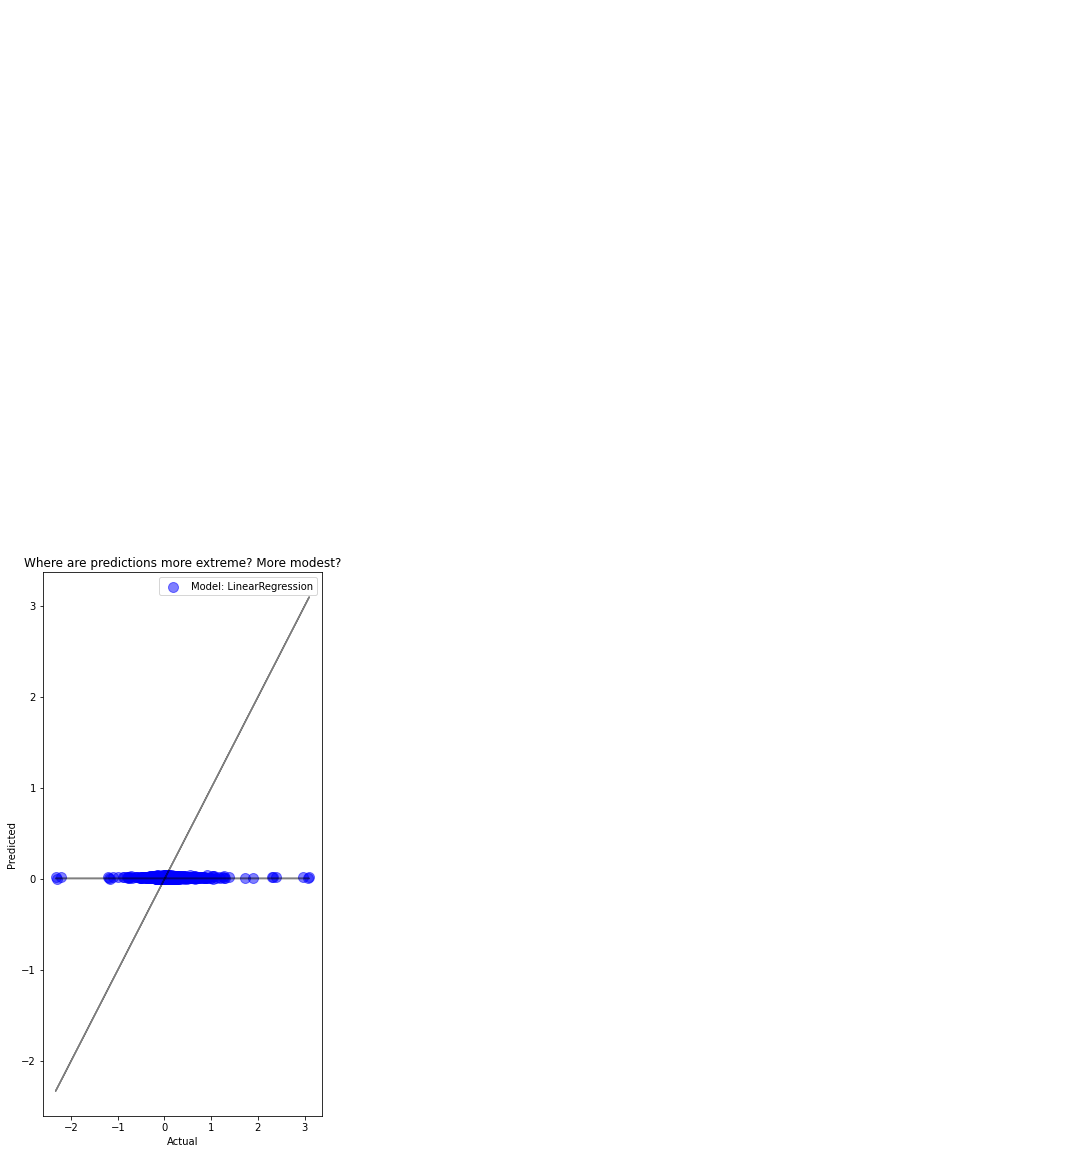

In [79]:
# y_validate.head()
plt.figure(figsize=(5, 10))
plt.plot(y_validate.logerror, y_validate.logerror_pred_median, alpha=.5, color="black", label='_nolegend_')
plt.annotate("Baseline: Predict Using Median", (16, 9.5))
plt.plot(y_validate.logerror, y_validate.logerror, alpha=.5, color="black", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm, 
            alpha=.5, color="blue", s=100, label="Model: LinearRegression")
plt.legend()
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

# LassoLars

In [82]:
# create the model object
lars = LassoLars(alpha=1.0)
    # what alpha is in this case
        # kidn of that regualizer that make lasso a little bit different
        # can go from 0 to infinity
            # it will eventually stop changing the efficivicy of you model 
                # depenind on th enumber of features being fed in
            # if alpha = 0 it is the same thing as a los model
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.logerror)
    # fit the thing
# predict train
y_train['logerror_pred_lars'] = lars.predict(X_train)
# evaluate: rmse
rmse_train_lars = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars)**1/2
# predict validate
y_validate['logerror_pred_lars'] = lars.predict(X_validate)
# evaluate: rmse
rmse_validate_lars = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars)**1/2
print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train_lars, 
      "\nValidation/Out-of-Sample: ", rmse_validate_lars)

RMSE for Lasso + Lars
Training/In-Sample:  0.012348907010552293 
Validation/Out-of-Sample:  0.011532822479710627


# Scatter Plot

Text(0.5, 1.0, 'Where are predictions more extreme? More modest?')

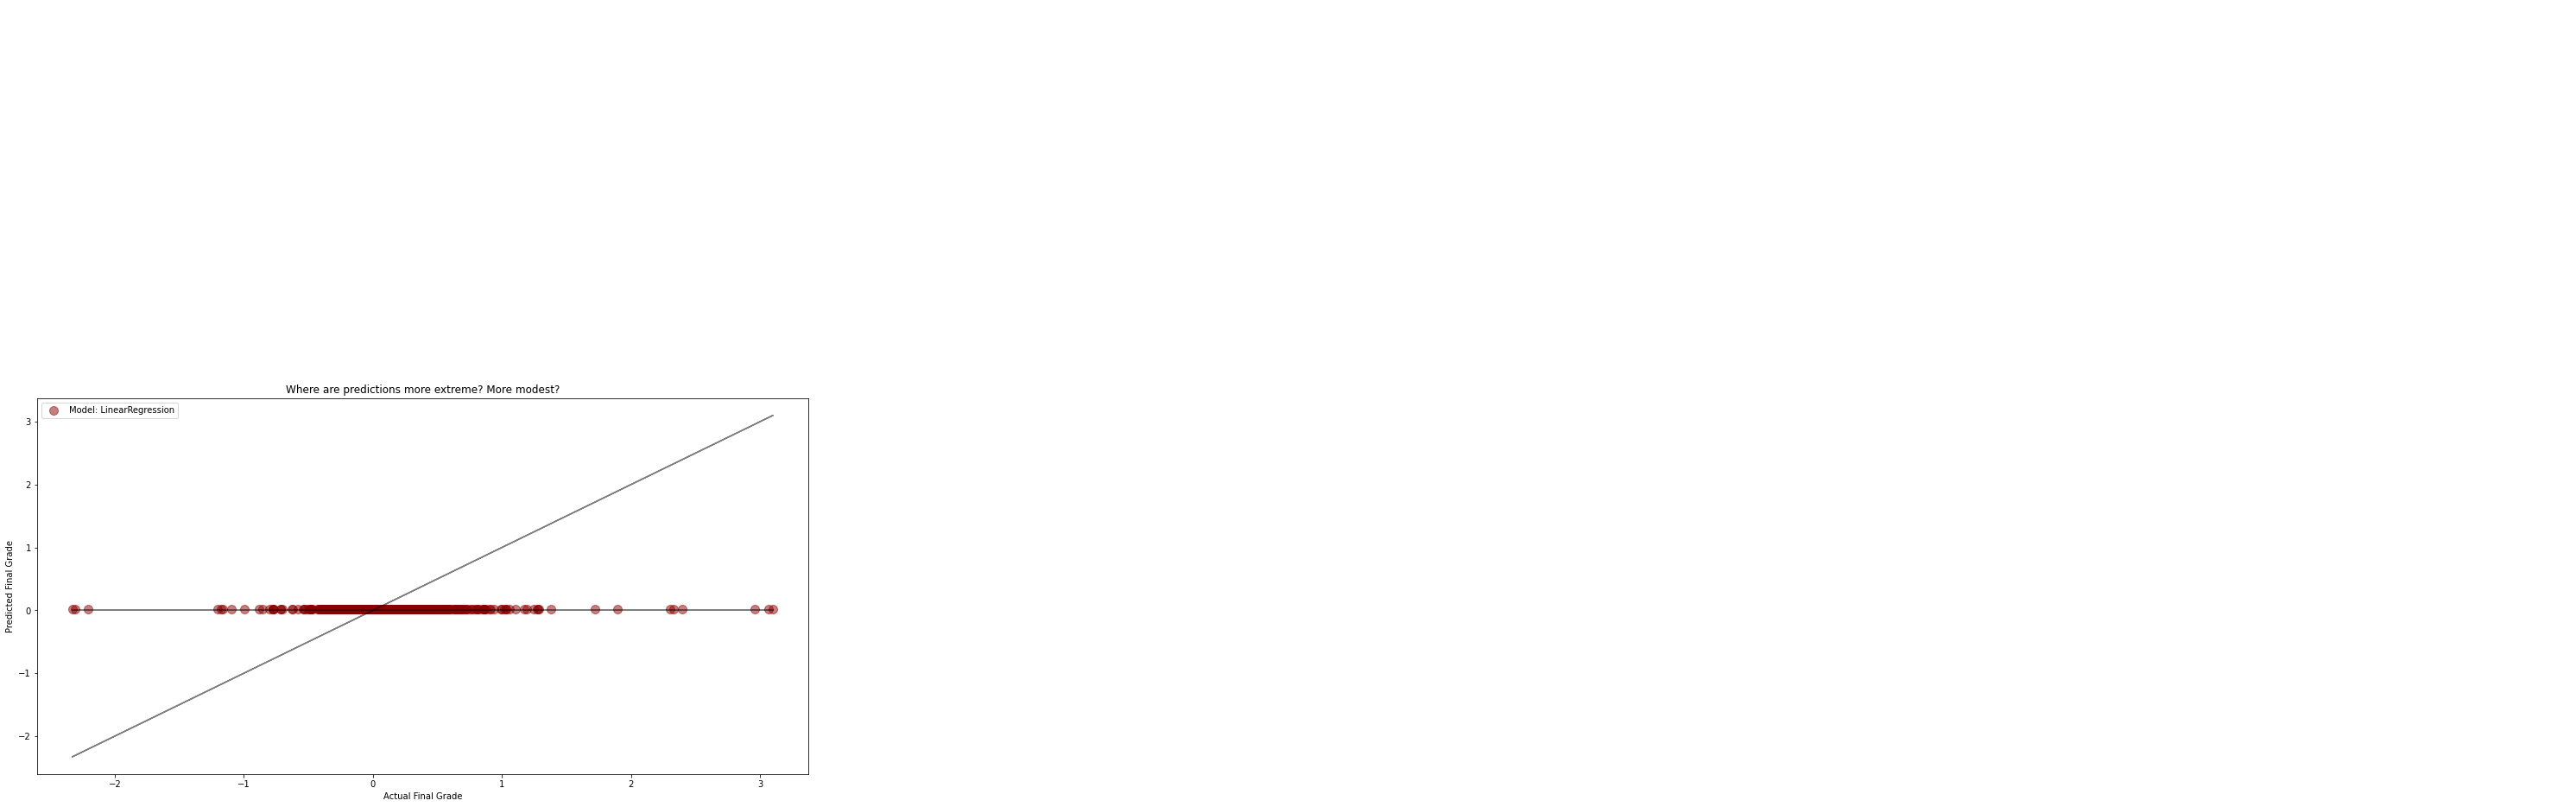

In [83]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.logerror, y_validate.logerror_pred_median, alpha=.5, color="black", label='_nolegend_')
plt.annotate("Baseline: Predict Using Median", (16, 9.5))
plt.plot(y_validate.logerror, y_validate.logerror, alpha=.5, color="black", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lars,
            alpha=.5, color="darkred", s=100, label="Model: LinearRegression")
plt.legend()
plt.xlabel("Actual Final Grade")
plt.ylabel("Predicted Final Grade")
plt.title("Where are predictions more extreme? More modest?")

# Tweedie Regressor

In [85]:
y_train.head()

,logerror,logerror_pred_mean,logerror_pred_median,logerror_pred_lm,logerror_pred_lars
18796,0.105114,0.015951,0.006026,0.012542,0.015951
3518,0.058315,0.015951,0.006026,0.005598,0.015951
15170,0.026213,0.015951,0.006026,0.016808,0.015951
13451,-0.041705,0.015951,0.006026,0.013474,0.015951
28664,-0.054827,0.015951,0.006026,0.019789,0.015951


<AxesSubplot:>

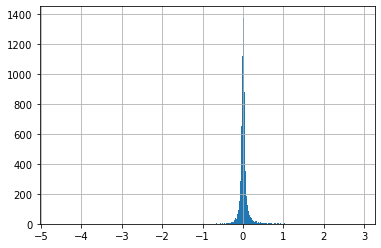

In [93]:
y_train.logerror.hist(bins = 1000)

In [94]:
# create the model object
glm = TweedieRegressor(power=0, alpha=0) # DO not set to 1 = pison
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.logerror)
# predict train
y_train['logerror_pred_glm'] = glm.predict(X_train)
# evaluate: rmse
rmse_train_glm = mean_squared_error(y_train.logerror, y_train.logerror_pred_glm)**1/2
# predict validate
y_validate['logerror_pred_glm'] = glm.predict(X_validate)
# evaluate: rmse
rmse_validate_glm = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_glm)**1/2
print("RMSE for GLM using Tweedie, power=0 & alpha=0\nTraining/In-Sample: ", rmse_train_glm, 
      "\nValidation/Out-of-Sample: ", rmse_validate_glm)

RMSE for GLM using Tweedie, power=0 & alpha=0
Training/In-Sample:  0.01234045919349956 
Validation/Out-of-Sample:  0.011536767590909373


# Scatter Plot

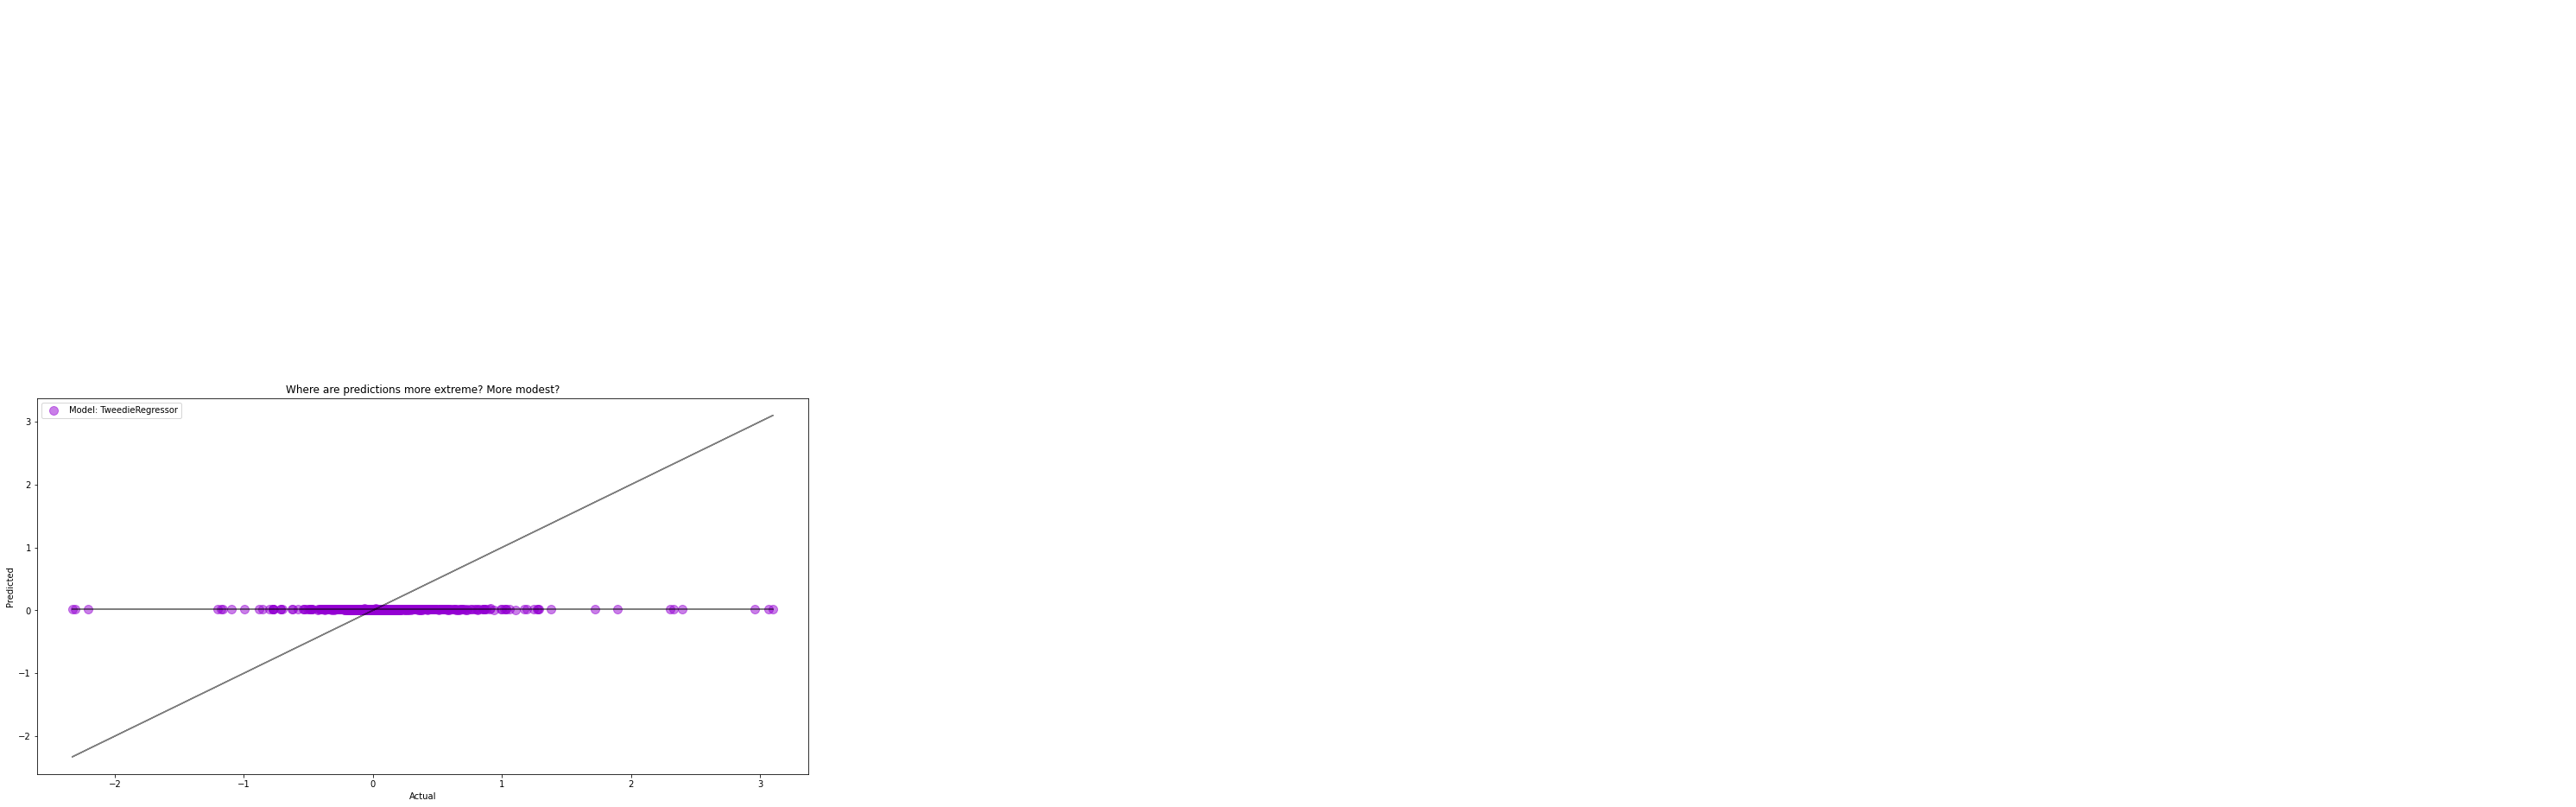

In [95]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.logerror, y_validate.logerror_pred_mean, alpha=.5, color="black", label='_nolegend_')
plt.annotate("Baseline: Predict Using Median", (16, 9.5))
plt.plot(y_validate.logerror, y_validate.logerror, alpha=.5, color="black", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)
plt.scatter(y_validate.logerror, y_validate.logerror_pred_glm, 
            alpha=.5, color="darkviolet", s=100, label="Model: TweedieRegressor")
plt.legend()
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

# Ploy Degree 2 

In [96]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)
# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)
# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
    # dont call fit transform just call transform
        # we only fit train not validate
X_test_degree2 = pf.transform(X_test)

In [97]:
# create the model object
lm2 = LinearRegression(normalize=True)
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.logerror)
# predict train
y_train['logerror_pred_lm2'] = lm2.predict(X_train_degree2)
# evaluate: rmse
rmse_train_lm2 = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm2)**1/2
# predict validate
y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_degree2)
# evaluate: rmse
rmse_validate_lm2 = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm2)**1/2
print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train_lm2, 
      "\nValidation/Out-of-Sample: ", rmse_validate_lm2)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.012288891953326782 
Validation/Out-of-Sample:  0.011543443686491118


# Scatter Plot

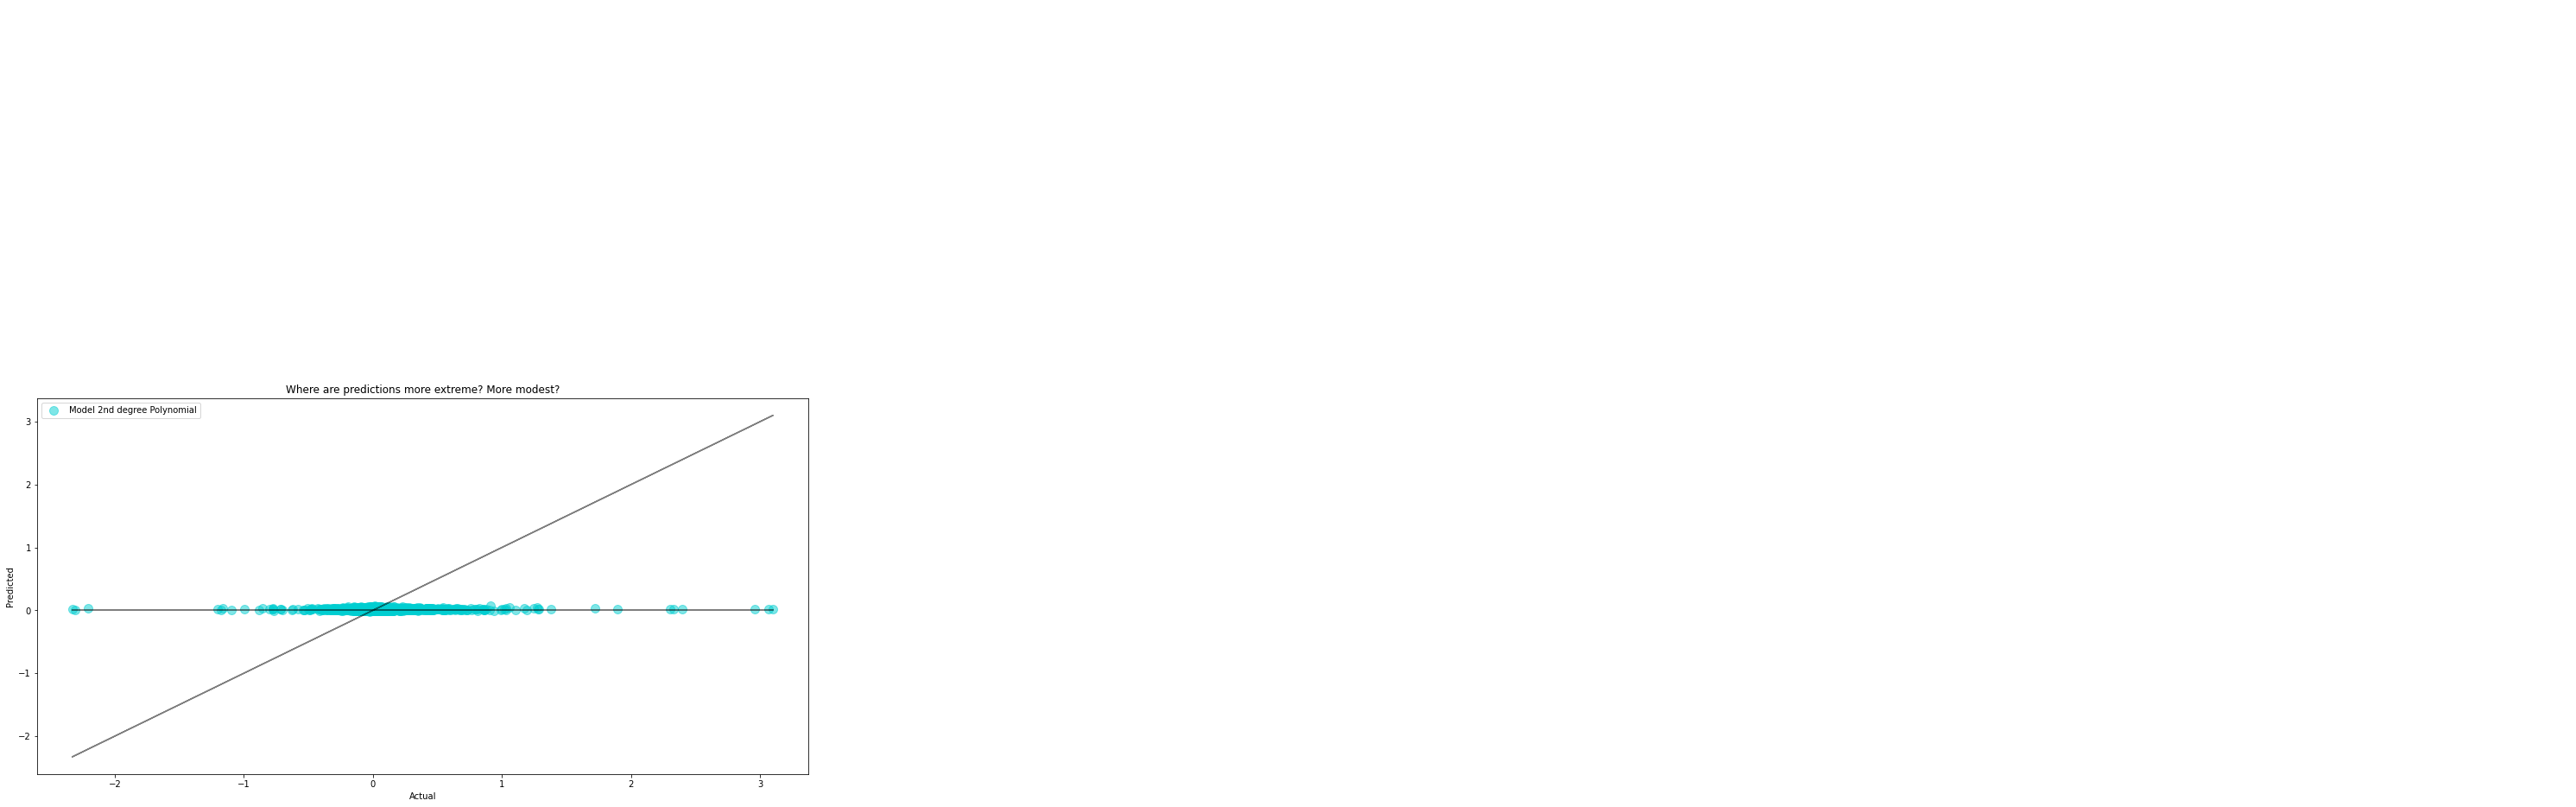

In [98]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.logerror, y_validate.logerror_pred_median, alpha=.5, color="black", label='_nolegend_')
plt.annotate("Baseline: Predict Using Median", (16, 9.5))
plt.plot(y_validate.logerror, y_validate.logerror, alpha=.5, color="black", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm2, 
            alpha=.5, color="darkturquoise", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

# Poly Degree 3 

In [99]:
# make the polynomial features to get a new set of features
pf3 = PolynomialFeatures(degree=3)
# fit and transform X_train_scaled
X_train_degree3 = pf3.fit_transform(X_train)
# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf3.transform(X_validate)
    # dont call fit transform just call transform
        # we only fit train not validate
X_test_degree3 = pf3.transform(X_test)

In [101]:
# create the model object
lm3 = LinearRegression(normalize=True)
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm3.fit(X_train_degree3, y_train.logerror)
# predict train
y_train['logerror_pred_lm3'] = lm3.predict(X_train_degree3)
# evaluate: rmse
rmse_train_lm3 = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm2)**1/2
# predict validate
y_validate['logerror_pred_lm3'] = lm3.predict(X_validate_degree3)
# evaluate: rmse
rmse_validate_lm3 = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm2)**1/2
print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train_lm3, 
      "\nValidation/Out-of-Sample: ", rmse_validate_lm3)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.012288891953326782 
Validation/Out-of-Sample:  0.011543443686491118


# Scatter Plot

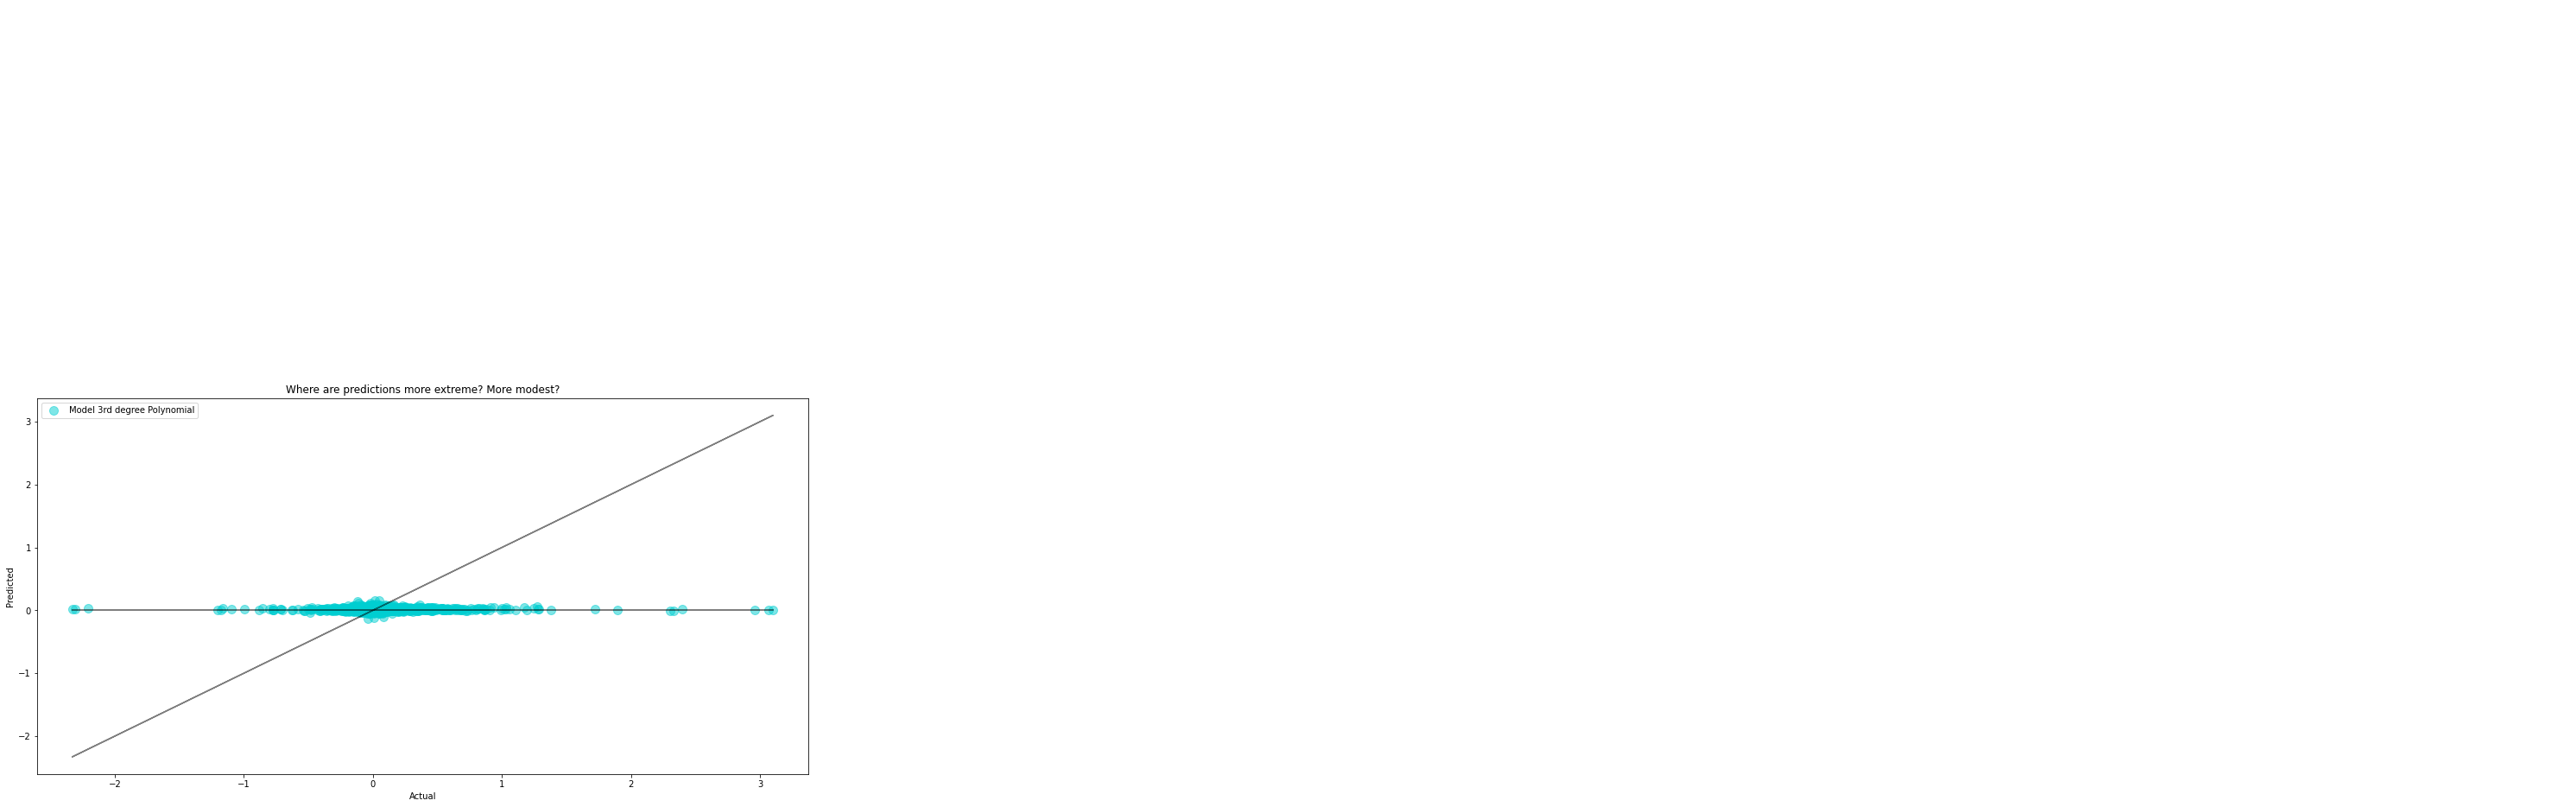

In [103]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.logerror, y_validate.logerror_pred_median, alpha=.5, color="black", label='_nolegend_')
plt.annotate("Baseline: Predict Using Median", (16, 9.5))
plt.plot(y_validate.logerror, y_validate.logerror, alpha=.5, color="black", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm3,
            alpha=.5, color="darkturquoise", s=100, label="Model 3rd degree Polynomial")
plt.legend()
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

# Linear Regression

In [107]:
import numpy as np

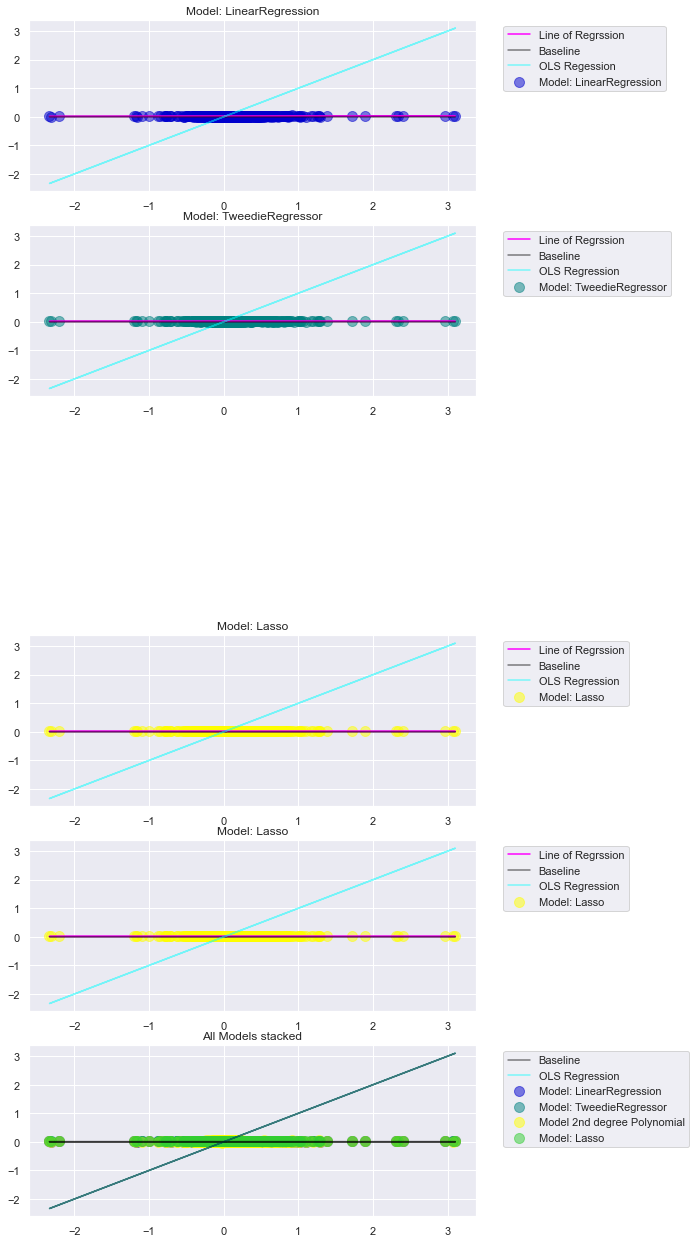

In [108]:
plt.subplots(6, 1, figsize=(8,22), sharey=True)
sns.set(style="darkgrid")
plt.subplot(6,1,1)
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm, 
            alpha=.5, color="mediumblue", s=100, label="Model: LinearRegression")
m, b = np.polyfit(y_validate.logerror, y_validate.logerror_pred_lm, 1)
plt.plot(y_validate.logerror, m*y_validate.logerror+b, color='fuchsia', label='Line of Regrssion')
plt.plot(y_validate.logerror, y_validate.logerror_pred_median, alpha=.5, color="black", label='Baseline')
plt.plot(y_validate.logerror, y_validate.logerror, alpha=.5, color="cyan", label='OLS Regession')
plt.title('Model: LinearRegression')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.subplot(6,1,2)
plt.scatter(y_validate.logerror, y_validate.logerror_pred_glm, 
            alpha=.5, color="teal", s=100, label="Model: TweedieRegressor")
m, b = np.polyfit(y_validate.logerror, y_validate.logerror_pred_glm, 1) 
plt.plot(y_validate.logerror, m*y_validate.logerror+b, color='fuchsia', label='Line of Regrssion')
plt.plot(y_validate.logerror, y_validate.logerror_pred_median, alpha=.5, color="black", label='Baseline')
plt.plot(y_validate.logerror, y_validate.logerror, alpha=.5, color="cyan", label='OLS Regression')
plt.title('Model: TweedieRegressor')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.subplot(6,1,3)
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm, 
            alpha=.5, color="limegreen", s=100, label="Model 2nd degree Polynomial")
m, b = np.polyfit(y_validate.logerror, y_validate.logerror_pred_lm2, 1) 
plt.plot(y_validate.logerror, m*y_validate.logerror+b, color='fuchsia', label='Line of Regrssion')
plt.plot(y_validate.logerror, y_validate.logerror_pred_median, alpha=.5, color="black", label='Baseline')
plt.plot(y_validate.logerror, y_validate.logerror, alpha=.5, color="cyan", label='OLS Regression')
plt.title('Model 2nd degree Polynomial')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.subplot(5,1,3)
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm3, 
            alpha=.5, color="limegreen", s=100, label="Model 3rd degree Polynomial")
m, b = np.polyfit(y_validate.logerror, y_validate.logerror_pred_lm3, 1) 
plt.plot(y_validate.logerror, m*y_validate.logerror+b, color='fuchsia', label='Line of Regrssion')
plt.plot(y_validate.logerror, y_validate.logerror_pred_median, alpha=.5, color="black", label='Baseline')
plt.plot(y_validate.logerror, y_validate.logerror, alpha=.5, color="cyan", label='OLS Regression')
plt.title('Model 2nd degree Polynomial')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.subplot(6,1,4)
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lars, 
            alpha=.5, color="yellow", s=100, label="Model: Lasso")
m, b = np.polyfit(y_validate.logerror, y_validate.logerror_pred_lars, 1) 
plt.plot(y_validate.logerror, m*y_validate.logerror+b, color='fuchsia', label='Line of Regrssion')
plt.plot(y_validate.logerror, y_validate.logerror_pred_median, alpha=.5, color="black", label='Baseline')
plt.plot(y_validate.logerror, y_validate.logerror, alpha=.5, color="cyan", label='OLS Regression')
plt.title('Model: Lasso')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.subplot(6,1,5)
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lars, 
            alpha=.5, color="yellow", s=100, label="Model: Lasso")
m, b = np.polyfit(y_validate.logerror, y_validate.logerror_pred_lars, 1) 
plt.plot(y_validate.logerror, m*y_validate.logerror+b, color='fuchsia', label='Line of Regrssion')
plt.plot(y_validate.logerror, y_validate.logerror_pred_median, alpha=.5, color="black", label='Baseline')
plt.plot(y_validate.logerror, y_validate.logerror, alpha=.5, color="cyan", label='OLS Regression')
plt.title('Model: Lasso')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.subplot(6,1,6)
plt.plot(y_validate.logerror, y_validate.logerror_pred_median, alpha=.5, color="black", label='Baseline')
plt.plot(y_validate.logerror, y_validate.logerror, alpha=.5, color="cyan", label='OLS Regression')
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm, 
            alpha=.5, color="mediumblue", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_glm, 
            alpha=.5, color="teal", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm2, 
            alpha=.5, color="yellow", s=100, label="Model 2nd degree Polynomial")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lars, 
            alpha=.5, color="limegreen", s=100, label="Model: Lasso")
plt.plot(y_validate.logerror, y_validate.logerror_pred_median, alpha=.5, color="black", label='_nolegend_')
plt.plot(y_validate.logerror, y_validate.logerror, alpha=.5, color="black", label='_nolegend_')
plt.title('All Models stacked')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

# Scatter Plot